# Introduction to Hypothesis Testing.

### Stephen Elston

### Data Science 350

***
**Required packages:** You must have the following packages installed to run this notebook.
- HistData
- dplyr
- pwr
***

## Introduction

This note book introduces you to the concepts of hypothesis testing. Specifically, this notebook covers the followig cases:

- Two sample tests for continious variables.
- Two sample tests for categorical or count data.
- Test for distributions.

![](img/HypothesisCartoon.png)
<center>**Testing a hypothesis**</center>

### Examples of hypothesis tests

What is a practical scenario of using hypothesis tests methods?

- **Identify a hypothesis that can be tested:** Using a larger logo on our web site will drive significantly more trafic.
- **Select a criteria to evaluate the hypothesis:** If our sample has a probability of $>= 90\%$ chance that the increase could be caused by randomness alone we will reject the null hypthesis that the logo does not mater.
- **Select a random sample from the population:** Randomly assign a cookie to new site users that tells the server to show A or B website.
- **Calculate a ststistic** to compare observations to what we expect to observe.

### Hypothesis testing steps

Let's illustrate the use of an hypothesis test with an example.

- We first state our population assumptions in the null hypothesis: $H_0$.
- We state our new alternative hypothesis as an alternative to the null: $H_a$.
- The null + alternative should make up all possible outcomes and be mutually exclusive.
  - $H_0 =$ The old website drives equal amount of traffic.
  - $H_a =$ The old website drives less traffic than the new one.
- Decide on a significance level (probability cutoff): 0.9, 0.95, and 0.99 are common (problem specific).

Based on our findings we can only do two things
- **Reject the null-hypothesis:** Since the alternative covers all other possibilities, we can say we accept the alternative hypothesis.
- **Fail to reject the null hypothesis:**  We accept the null hypothesis because we have already believed our null hypothesis from the start. We can fail for two reasons:
  - The alternative hypothesis was false to begin with.
  - We did not collect enough evidence for the **size of the effect**

In [1]:
prob_normal = function(a, b, mean=0, sd=1){
  stopifnot(a<=b) # Test input condition
  return(pnorm(b,mean,sd) - pnorm(a,mean,sd))
}

#One tailed
prob_normal(20.1262055, Inf, 15, 4) # 10% of the area lies to the right of 20.1262055 on N(15,4)

[1] 0.1

You can verify that the probability of the entire distribution is 1.0 by executing the code in the cell below.

In [2]:
prob_normal(-Inf,Inf)

[1] 1

**Your Turn:** find the probability of a standard Normal in the following intervals:
- -1 to 1
- -2 to 2
- -3 to 3

In [3]:
Map(function(a,b) prob_normal(a, b), c(-1, -2, -3), c(1, 2, 3))

[[1]]
[1] 0.6826895

[[2]]
[1] 0.9544997

[[3]]
[1] 0.9973002

### What does the cutoff mean?

- We know that the average time a user spends on a page has a mean of 15 seconds and a s.d. of 4 seconds.
- If we assume normality, how do we test if a change to the page has a higher view time?
- For example, an event in the blue region will have a 10% chance or less of occurring.

![](img/cutoff.jpg)

**Reject the Null Hypothesis with $90\%$ confidence:** if the mean of the time spent on the new web page is in the blue region. 

The code in the cell below computes the $90\%$ cutoff for a Normal distribution with a mean of 15 and a standard deviation of 4. 

In [4]:
cutoff_stat = function(alpha, mean=0, sd=1, one_tailed=TRUE){
  stopifnot((alpha>0) & (alpha<1))
  if (one_tailed){
    return(qnorm(1-alpha, mean, sd))
  }else{
    return(qnorm(1-(alpha/2), mean, sd))
  }
}

cutoff_stat(0.1, 15, 4)

[1] 20.12621

You can be $90\%$ confident that a value greater than 20.1 is drawn from another population. 

### How many tails do you have?

The above is a one-sided hypothesis test. But, **be careful** as there are other alternatives! Could the new web site be worse? In fact, there are **three possibilities** for which tail(s) used to evalutate the test, as shown in the figure.

![](img/tails2.jpg)

The accept-rejection criteria for the null hypothesis is different in each case.

- One-tail test with value $\gt$ the cutoff.
- One-tail test with value $\lt$ the cutoff.
- Two-tail test with value $\lt\ -cutoff/2$ or $\gt\ cutoff/2$.


### What is  the p-value?

Results of hypothesis tests are often reported as a p-value. You must be careful to correctly interpret the p-value. 

- In technical terms, a p-value is the probability of obtaining an effect **at least as extreme** as the one in your sample data, assuming the null hypothesis is true.
For example, for a vaccine study with a p-value of 0.04, you’d obtain the observed difference or more in 4% of studies due to random sampling error.
P values address **only one question: how likely are your data, assuming a true null hypothesis?** 
- **P value does not measure support for the alternative hypothesis!**


### Misuse of p-values

But, watch out! There are many ways to mis-interpret or misuse p-values.

1. The most common mistake: interpreting a P value as the probability of mistakenly rejecting a true null hypothesis (a **type I error**).
  - P values calculations assume the null hypothesis is true for the population and the difference in the sample is entierly from random chance. **P values can’t tell you the probability that the null is true or false!** 
  - For the vaccine study, correct and incorrect way to interpret a P value of 0.04:
    * Correct: If vaccine has no effect,  **the observed difference or more arises solely from random sampling error in 4% of studies.**
    * Incorrect: By rejecting the null hypothesis, there’s a 4% chance of Type 1 error.
2. The second common mistake: you can deduce the probability that the alternative hypotheis is correct (e.g. $1.0 - p$, or a **type II error**).  

## A First Example: t-test

The Student t-test is one of the oldest and widely used hypothesis test. Student’s T-test: tests a hypothesis about the difference of two data samples:
- Test whether a population mean has a specified value.
- Test the difference between two means (equal, unknown variances).
- Test a paired-response difference from zero. E.g. a before/after drug treatment on patients.
- Test whether the slope of a line is not zero.
- Test the importance of variables (later in class).
- Use ‘Welch’s T-test’ for testing the difference between two means (unknown variances, potentially different).
- **Picking the different tests changes test’s results.**
- The more assumptions we make, the easier it is to tell the difference between populations.

### Who was Student?

Student was a pseudonym for William Sealy Gosset. Gosset worked for Guinness Company which forbade employees from publishing work. Gosset published the theory of the t-test in 1908.  

![](img/Gosset_1908.jpg)
<center>**William Sealy Gosset in 1908**</center>

![](img/gossett.jpg)

<center>**Plaque at site of Gosset's home**</center>

### Why the t-distribution

The differene in means between two Normal distributions with unknown variance follows a t-distribution. The t-distribution has many nice properties including:

- The t-distribution is the natural distribution for tests on means.
- The t-distribution has heavier tails than the Normal and relaxes assumptions on the differences.


###  A first example

As a first example, compare the means of two Normal distributions. Execute the code in the cell below to compute samples from two Normal distributions.

In [9]:
pop_A = rnorm(25, mean=150, sd = 7)
pop_B = rnorm(25, mean=153, sd = 4)

Loading required package: repr
Warning message:
"package 'repr' was built under R version 3.3.3"

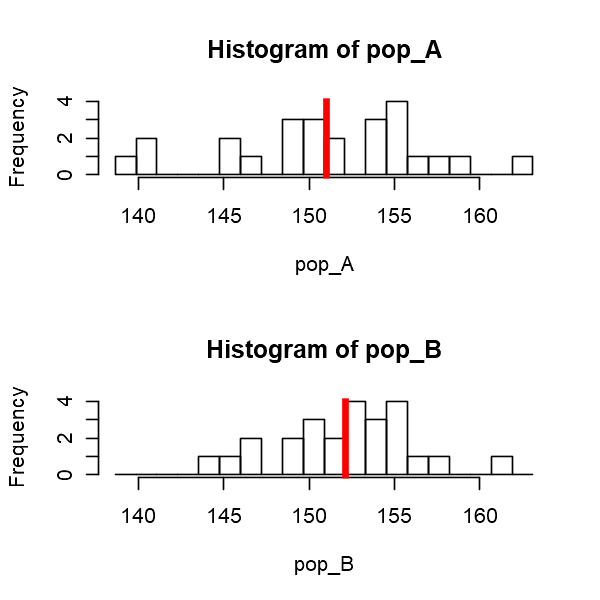

In [6]:
require(repr)
options(repr.plot.width=5, repr.plot.height=5) ## Set the plot area.

plot.t <- function(a, b, cols = c('pop_A', 'pop_B'), nbins = 20){
  maxs = max(c(max(a), max(b)))
  mins = min(c(min(a), min(b)))
  breaks = seq(maxs, mins, length.out = (nbins + 1))
  par(mfrow = c(2, 1))
  hist(a, breaks = breaks, main = paste('Histogram of', cols[1]), xlab = cols[1])
  abline(v = mean(a), lwd = 4, col = 'red')
  hist(b, breaks = breaks, main = paste('Histogram of', cols[2]), xlab = cols[2])
  abline(v = mean(b), lwd = 4, col = 'red')
  par(mfrow = c(1, 1))
}
plot.t(pop_A, pop_B)

You can now compute the two-sided t-test by executing the code in the cell below.

In [10]:
## Two-tailed test
t.test(pop_A, pop_B, alternative = "two.sided")


	Welch Two Sample t-test

data:  pop_A and pop_B
t = -2.9178, df = 37.626, p-value = 0.005917
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -8.374591 -1.512596
sample estimates:
mean of x mean of y 
 149.5692  154.5128 


**Your Turn:** Compute and compare the results of the one-sided t-test for one mean being greater than the other and compare the results to the ones above. **Hint**, the argument is `alternative = "greater"`. 

In [12]:
t.test(pop_A, pop_B, alternative = "less")


	Welch Two Sample t-test

data:  pop_A and pop_B
t = -2.9178, df = 37.626, p-value = 0.002959
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -2.086415
sample estimates:
mean of x mean of y 
 149.5692  154.5128 


### Power of Tests

The **power of a test** is formally defined as:

$$power = P(reject\ H_0| when\ H_a\ is\ true)$$

In pain language, the power is the probability of getting a positive result when the null hypothesis is not true. Conversely, a test with insuficient power will not detect a real effect. Clearly, we want the most powerful test we can find for the situation. 

Computing test power can be a bit complex, and analytical solutions can be dificult or impossible. Often, a simulation is used to compute power. 

Let's look at the example of compution power for the two sample t-test for the difference of means. The power of this test depends on the several parameters:

- The number of samples.
- The anticipated difference in the population means, which we call the **effect**.
- The significance level of  the test.
- The type of test.

When running a power test, you can ask several questions, which will assist you in designing an experiement. Usually, you will determine how big a sample you need to have good chance of rejecting the null hypothesis. You can also determine how big an effect needs to be given a fixed sample size (all the samples you have or can afford) to have a good chance of rejecting the null hypothesis. 

The R `pwr` package provides functions for computing the power of many common tests. You can learn more about using this package from the [vingette](https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html) on CRAN.

The code in the cell below does the following:

- Ensure the `pwr` package is loaded. 
- Create a sequene of effect sizes.
- Compute a vector of power values for the effect size.
- Plot the effect size vs. power. 

Execute this code and examine the result. 

Loading required package: pwr
Warning message:
"package 'pwr' was built under R version 3.3.3"

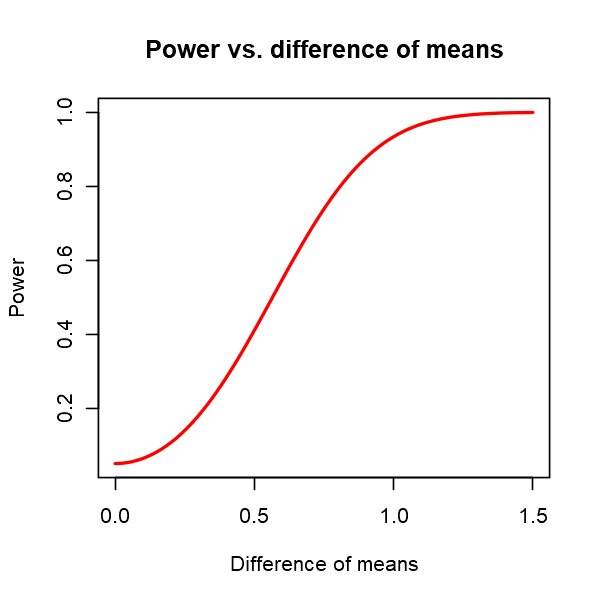

In [13]:
require(pwr)

X = seq(from = 0.0, to = 1.5, length.out = 100)
powers = sapply(X, function(x) 
    pwr.t.test(n = 25, d = x, sig.level = 0.05, power = NULL,
    type = "two.sample", alternative = "two.sided")$power)
    
plot(X, powers, type = 'l', lwd = 2, col = 'red',
    xlab = 'Difference of means', ylab = 'Power',
    main = 'Power vs. difference of means')

***
**Your turn:** In the code cell below, compute and plot 100 values of test power for significance levels in the range $\{0.001, 0.1\}$. Set `n = 25`, `d = 1.0`, for the number of samples and the difference in means.
***

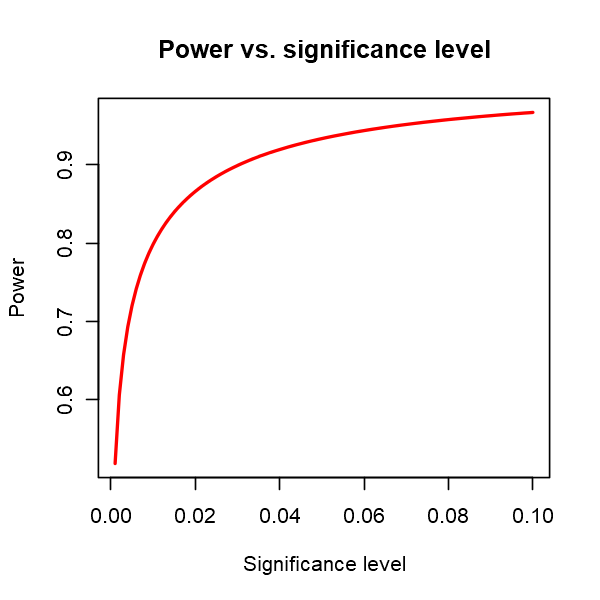

In [14]:
X = seq(from = 0.001, to = 0.1, length.out = 100)
powers = sapply(X, function(x) 
    pwr.t.test(n = 25, d = 1.0, sig.level = x, power = NULL,
    type = "two.sample", alternative = "two.sided")$power)
    
plot(X, powers, type = 'l', lwd = 2, col = 'red',
    xlab = 'Significance level', ylab = 'Power',
    main = 'Power vs. significance level')

***
**Your turn:** In the code cell below, compute and plot 100 values of test power for sample size in the range $\{1, 100\}$. Set `d = 1.0`, and `sig.level = 0.05`, for the difference in means and the significance level.
***

Warning message in qt(sig.level/tside, nu, lower = FALSE):
"NaNs produced"

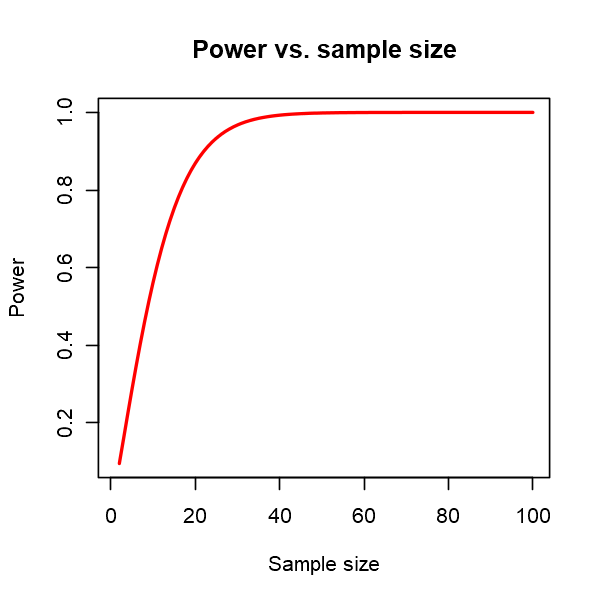

In [15]:
X = seq(from = 1, to = 100, length.out = 100)
powers = sapply(X, function(x) 
    pwr.t.test(n = x, d = 1.0, sig.level = 0.05, power = NULL,
    type = "two.sample", alternative = "two.sided")$power)
    
plot(X, powers, type = 'l', lwd = 2, col = 'red',
    xlab = 'Sample size', ylab = 'Power',
    main = 'Power vs. sample size')

### Tests on Gaulton's height data (1886)

Francis Gaulton published his seminal paper on the theory of regression in 1886. This paper has been enourmously infulential in statistics, as the linear regression model is still used today; in a different form from Gaulton's approach. 

Gaulton showed that the hights of members of a family 'regress to the mean', and that the height of the parents does not determine the hights of their adult childern. In this exercise, we will take a different approach to analyzing these data. We will use the t-test to compare the difference in means of the hights of parents and their adult childern. 

As a first step, load the R HistData package and have a look at the first few rows of the data frame by executing the code in the cell bellow. 

In [17]:
library(HistData)
head(GaltonFamilies)

family,father,mother,midparentHeight,children,childNum,gender,childHeight
001,78.5,67.0,75.43,4,1,male,73.2
001,78.5,67.0,75.43,4,2,female,69.2
001,78.5,67.0,75.43,4,3,female,69.0
001,78.5,67.0,75.43,4,4,female,69.0
002,75.5,66.5,73.66,4,1,male,73.5
002,75.5,66.5,73.66,4,2,male,72.5


This data set has 9 columns:
 1. A case or row number.
 2. A unique code for each family in the sample.
 3. The height of the father in inches.
 4. The height of the mother in inches.
 5. The average height of the parents.
 6. The number of childern in the family.
 7. A code for the each unique child in the family.
 8. The gender of the child.
 9. The height of the adult child in inches. 
 
 To analyze these data we divide them into two groups based on the gender of the adult childern. The code in the cell below divides the data set, plots two histograms to compare the hights of the two samples and performs two-sided the t-test on difference of the means of these samples. 


	Welch Two Sample t-test

data:  male$childHeight and female$childHeight
t = 31.476, df = 929.89, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 4.810266 5.449979
sample estimates:
mean of x mean of y 
 69.23410  64.10397 


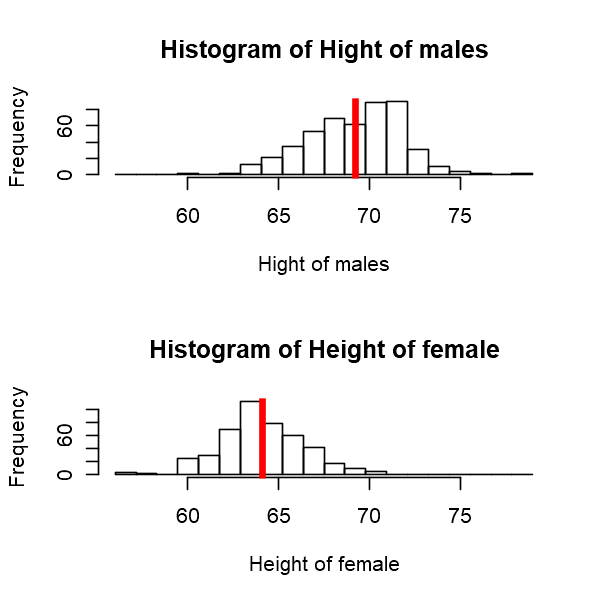

In [18]:
## Is the average height of men different from women?
male = GaltonFamilies[GaltonFamilies$gender == 'male',]
female = GaltonFamilies[GaltonFamilies$gender == 'female',]
plot.t(male$childHeight, female$childHeight, cols = c('Hight of males', 'Height of female'))
t.test(male$childHeight, female$childHeight, alternative = "two.sided")

**Your Turn:** Compute the t-statistics and histograms for the difference in means of the fathers and their adult sons.


	Welch Two Sample t-test

data:  male$childHeight and male$father
t = 0.60568, df = 944.4, p-value = 0.5449
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2160976  0.4090290
sample estimates:
mean of x mean of y 
 69.23410  69.13763 


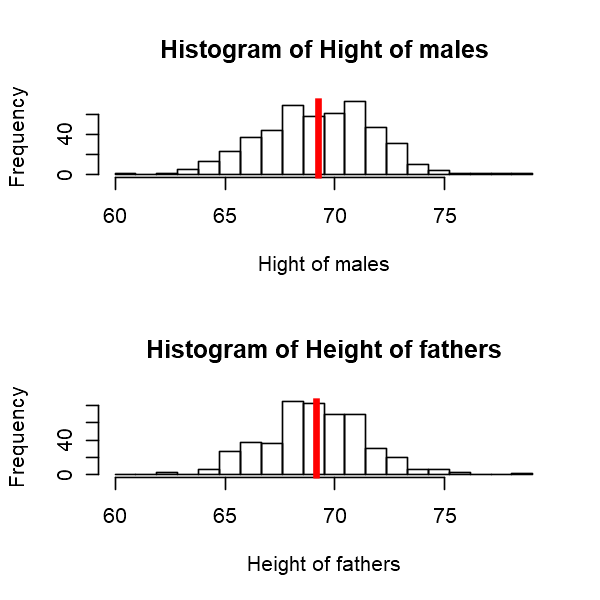

In [19]:
plot.t(male$childHeight, male$father, cols = c('Hight of males', 'Height of fathers'))
t.test(male$childHeight, male$father, alternative = "two.sided")

There is also a version of the t-test for paired data. The heights of mothers and their adult sons is an example of paired data, since each son has a specific mother. Clasically, paired tests are used to compare data from before and after a treatment.

Execute the code in the cell below and  examine the results.


	Paired t-test

data:  male$mother and male$childHeight
t = -39.498, df = 480, p-value < 2.2e-16
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf -4.98383
sample estimates:
mean of the differences 
              -5.200832 


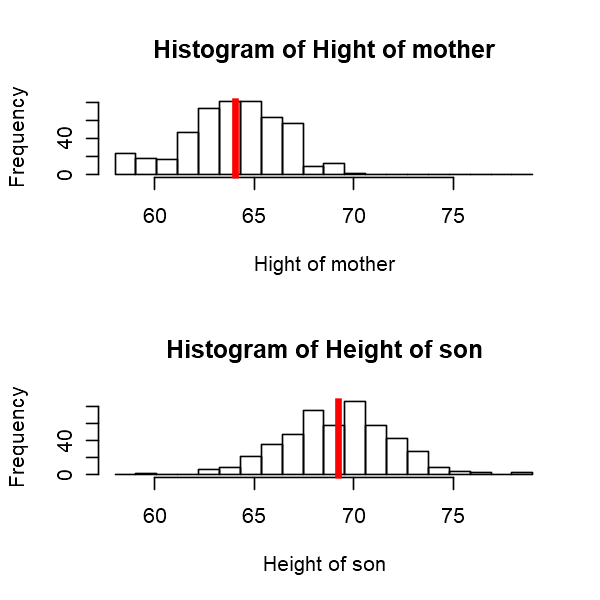

In [22]:
## Welche's test for paired data
plot.t(male$mother, male$childHeight, cols = c('Hight of mother', 'Height of son'))
t.test(male$mother, male$childHeight, alternative = "less", paired = TRUE)

***
**Your turn:** You have seen that we cannot reject the null hypothesis for a difference in means of the fathers and their sons, which was only about `0.1`. It could be that this is an issue with test power. 

In the code cell below use the `pwr.t2n.test` function to plot 100 values of the difference in means in the range $\{0.0, 0.5 \}$. The sample size arguments to this function are `n1 and n2`, and the `sig.level - 0.05`. 

Execute your code and examine the results. How big should the difference be to have a power or 0.9? 
***

In [ ]:
length(male)

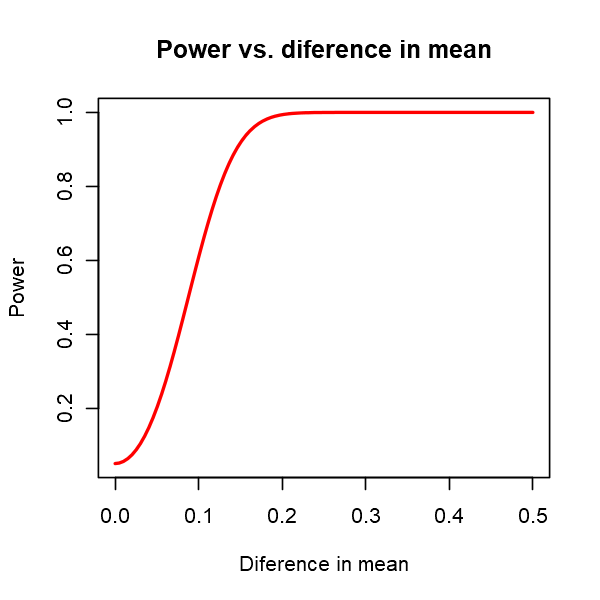

In [24]:

X = seq(from = 0.0, to = 0.5, length.out = 100)
powers = sapply(X, function(x) 
    pwr.t2n.test(n1 = 1000, n2 = 1000, d = x, sig.level = 0.05, power = NULL,
   alternative = "two.sided")$power)
    
plot(X, powers, type = 'l', lwd = 2, col = 'red',
    xlab = 'Diference in mean', ylab = 'Power',
    main = 'Power vs. diference in mean')

## Tests for Categorical Data

So far, we have been investigating tests for data with continious values. But, many data types are categorical where we work with count statistics. What tests can we apply to these?

### Pearson's Chi-Squared Test

One of the earliest tests for count data was developed by Karl Pearson around 1900. Dispite its age, this test is still used today. The Pearson Chi-squared test (also written as $\chi$-squared) has the following properties:

- It is an unpaired test for counts in different categories.
  - These categories must be mutually exclusive. For example, does the patient have cancer? (yes/no)
  - Test if the two categories differ in WBC count.
  - Rolling a die. (1,2,3,4,5,6)
  - Test if the six categories occur the same (fair die).
  - Does a tweet contain a specific word? (yes/no)
  - test if the two categories differ in tweet length or word count.
- Tests if different categories differ in some specific value.
- The Chi-squared statistic depends on the ‘degrees of freedom’ of the test.
  - This is equal to n-1.  Where n equals the number of different categories.
- The test looks at the sum of the outcome differences from expectations.
- Chi-squared is also used for a ‘goodness of fit’ test. Test if sample is representative of population.
  - Test if your sample has expected make up of categories.
  - For example, if our population is 50-50 men-women, then we test if our sample is different from those expected probabilities.

The density of the $\chi$-squared distribution depends on the degrees of freedom.

![](img/Chi-square.png)

As with any probability density function, confidence intervals and p-values can be computed. Notice that the $\chi$-squared distribution becomes flatter and with greater dispursion as the degrees of freedom increase. In practice, this means that you will need large samples to get a meaningful result if you have too many choices in your test. 

### Karl Pearson

Karl Pearson was the dean of late 19th and early 20th century mathematical statisticians. Pearson was a student of Frances Gaulton, the inventor of the regression method. Willam Sealy Gossett was one of Pearsons's students. This realationship is said to be the insparation for Gossett's pseudonym 'Student'. 

![Karl Pearson in 1912: A scary looking statistics professor](img/Karl_Pearson_1912.jpg) 

<center>**Karl Pearson in 1912:** A scary looking statistics professor!</center>

In many ways Pearson's infuluence on the mathematical foundations of statistics is still with us more than a century latter. Most unfortunately, Pearson was also a eugenicist and a raceist. His misuse of statistics in this area tarnished his legacy.

### Building a Chi-squared table

The traditional way to apply a Chi-squared test is to first create a Chi-squared table. In this example we are looking the results of an A-B test with three possible outcomes. For example, this type of test might be applied to determine if a new web site drives more customer purchases. 

the code in the cell below builds a simple Chi-squared table. The columns in the data frame are:

- The actual occurance of events.
- The expected probability of these events. This is the distribution of the null hypothesis.
- The expected occurance of events given the expected probabilities.
- The difference between the occurance and the expected number of events.
- The square of the difference.
- The squared difference normalized by the expected number of occurances. The sum of these figures in the Chi-squared statistic. 

Execute the code and examine the results. 

In [25]:
require(dplyr)
ab_data = data.frame(Action = c('Leave Page', 'Continue Purchase', 'Add More to Purchase'), 
                     occurrence=c(55,43,22),
                     expected_per=c(0.6,0.3,0.1))
ab_data = mutate(ab_data, expected_occurance = sum(occurrence) * expected_per)
ab_data = mutate(ab_data, diff = occurrence - expected_occurance)
ab_data = mutate(ab_data, sqr_diff = diff^2)
ab_data = mutate(ab_data, diff_expec = sqr_diff/expected_occurance)
ab_data = rbind(ab_data,
               data.frame(Action = 'Totals', occurrence = sum(ab_data$occurrence), 
                          expected_per = NA, expected_occurance = NA, diff = NA,
                         sqr_diff = NA, diff_expec = sum(ab_data$diff_expec)))

ab_data

Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Action,occurrence,expected_per,expected_occurance,diff,sqr_diff,diff_expec
Leave Page,55,0.6,72,-17,289,4.013889
Continue Purchase,43,0.3,36,7,49,1.361111
Add More to Purchase,22,0.1,12,10,100,8.333333
Totals,120,NA,NA,NA,NA,13.708333


This Chi-squared table is interpreted as follows:

- The $\chi$-squared test statistic is 13.708, which is computed as the sum of the squared differences normalized by the observerd occurances.
- The $\chi$-squared distribution has (3-1)=2 degrees of freedom.
- Degree of freedom is the number of options (3) minus 1.

Run the  code in the cell below to compute the results of the chi-squared test in R.

In [26]:
chisq.test(ab_data$occurrence[1:3], p = ab_data$expected_per[1:3])
1-pchisq(ab_data$diff_expec[3], df=2) # Compute the p-value


	Chi-squared test for given probabilities

data:  ab_data$occurrence[1:3]
X-squared = 13.708, df = 2, p-value = 0.001055


[1] 0.01550385

The difference between the expected and observed number of occurances is significant. The large Chi-squared value on 2 degrees of freedom and the small p-value indicate we can reject the null hypothesis that the observed occurances follow the same distribution as the expected occurances. 

Finally, we should check the power of our test. Execute the code in the cell below and examine the results. Does this test have reasonable power?

In [27]:
pwr.chisq.test(w = 8, N = 12, df = 2, sig.level = 0.05, power = NULL)


     Chi squared power calculation 

              w = 8
              N = 12
             df = 2
      sig.level = 0.05
          power = 1

NOTE: N is the number of observations


### Fisher's Exact Test

The assumptions behind the Chi-squared statistic breakdown when the sample size is small (e.g. number of occurances $\le 10$). In this case you can use Fisher's Exact Test. In practice Fisher's exact test is rarely used, but it is interesting  to think about it anyway. 

According to the story, in 1911 Ronald Fisher worked in the same institutioin with a talented aquatic bonanist, Dr. Muriel Bristol, who was quite particular about how her tea was served. Dr. Bristol told Fisher that she could tell the difference between cups of tea where the milk had been poured into the cup before or after the tea was poured. 

![](img/Bristol.png)
<center>**Dr Murel Bristol**, noted algal botanist, and quite particular about her tea.

Fisher, was a bit skeptical. He challenged Dr. Britol to a test. In the test Fisher prepared eight cups of tea. Four of the cups of where prepared in Dr. Bristol's prefered manner and the other four the other way. The tea was prepare out of sight of Dr. Bristol. However, she knew that there were four cups prepared each way. The order of preparation of each cup of tea was randomized. Fisher served the cups of tea to Dr. Bristol and asked her how the tea had been poured. In every case, she was correct!

Fisher devised a **purmutation test** to determine the likelihood that Dr Bristol could have simiply guessed the correct outcome. He devised the following purmuation table for the chances of success:

![](img/tea.png)

The possible purmuations of possible ways that Dr Bristol could have correctly (sucess) or incorrectly identified the way each cup of tea was prepared:

$$\frac{8!}{4!(8-4)!} = 70$$

So, the chance that the Dr Bristol could purely guess (by random chance) the outcome is only 1 in 70 or about 1.4%. 

Let's try an example of Fisher's exact test in R. Take a simple 2X2 matrix of counts. The counts are number of success and failures for two samples (two sets of Bernoulli trails). Run the code in the cell below to apply the Fisher exact test to these counts.  

In [28]:
mat_test = matrix(c(2,3,3,4), nrow=2, byrow=TRUE)
mat_test
fisher.test(mat_test, alternative = "less")

2,3
3,4



	Fisher's Exact Test for Count Data

data:  mat_test
p-value = 0.6894
alternative hypothesis: true odds ratio is less than 1
95 percent confidence interval:
  0.0000 10.3061
sample estimates:
odds ratio 
 0.8976455 


In this case, we must accept the null hypothesis. The p-value is large and the confidence interval includes 0. 

## Hypothesis Testing Summary

If data is normal:
- If you know population mean and variance,
  - Use standard normal ‘z-test’.
  - If you just know population mean, use t-test.
  - If you don't know the mean and variance, use Welch’s t-test.
  - Tests for paired and unpaired data.
- For categorical comparison tests,
  - If the sample/subgroup size is large enough, use Chi-squared test
  - If the sample/subgroup size is small, use Fisher’s Exact test.


## Testing distributions

Test statistics, and other statistics, often make distribution assumptions. This raises the question, how can we test a distribution assumption. To answer this question we will now look at both graphical and  formal tests.  

### An example with Q-Q plot

The qualtile-quantile (Q-Q) plot provides a handy visual means to inspect the Normality of a data set. The Q-Q plot plots the quantiles of a standard Normal distribution on the horizontal axis and the quantiles of the data sample on the vertical axis. If the sample is Normal the data points will fall in a straight line. 

Execute the code in the cell below to compute two samples from a Normal distribution.

In [29]:
norm1 = rnorm(100,mean=0,sd=1)
norm2 = rnorm(100,mean=0,sd=1)

Run the code in the cell below to create Q-Q plots of the two samples, and examine the results.

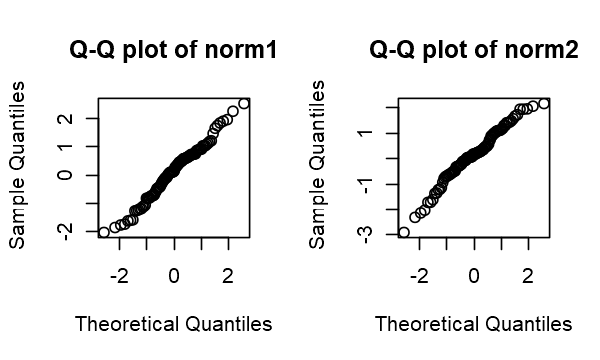

In [30]:
options(repr.plot.width=5, repr.plot.height=3)

# Visual test of normality
par(mfrow = c(1, 2))
qqnorm(norm1, main = 'Q-Q plot of norm1')
qqnorm(norm2, main = 'Q-Q plot of norm2')
par(mfrow = c(1, 1))

The line of points on both Q-Q plots is close to straight, showing the not suprising result given that both samples are realizations of Normal distributions.

You can also test if two samples have similar distributions using the same plot. Run the code in the cell below and examine the result. 

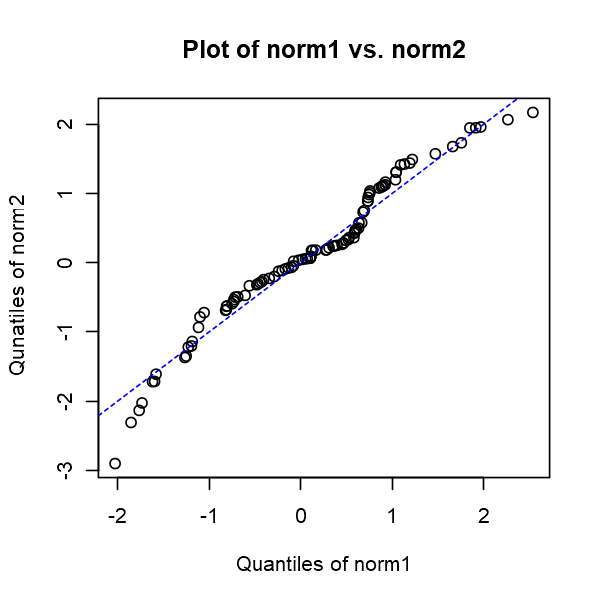

In [31]:
options(repr.plot.width=5, repr.plot.height=5)

## Or, plot one distribution against another.
plot(sort(norm1), sort(norm2), main = 'Plot of norm1 vs. norm2', 
     xlab = 'Quantiles of norm1', ylab = 'Qunatiles of norm2')
abline(a = 0.0, b = 1.0, lty = 2, col = 'blue')

Again, not suprisingly, the points line on a straight line.

### The Kolmogorov-Smirnov test for distributions

The Kolmogorov-Smirnov test a general test of a distribution. The K-S statistic is just the maximum vertical distance between two CDFs. Since it is based on a simple deviatiion the K-S test can test departure from any hypothetical distribution, not just normal.

As a first step in investigating the Kolmogorov-Smirnov test plot the cumulative distribution functions of the two samples by executing the code in the cell below.

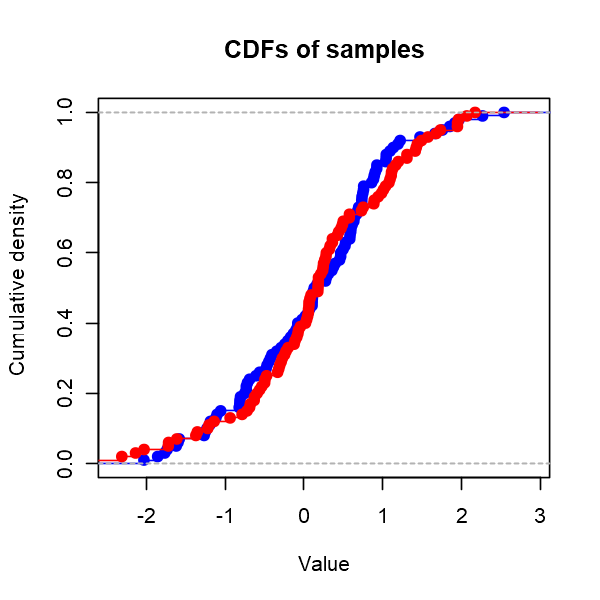

In [32]:
## Plot the cdfs
plot(ecdf(norm1), col='blue', main ='CDFs of samples', 
     xlab = 'Value', ylab = 'Cumulative density')
lines(ecdf(norm2), col='red')

The samples must be standardized before applying the Kolmogorov-Smirnov test. Execute the code in the cell below to standardize and plot the cdf of the samples.

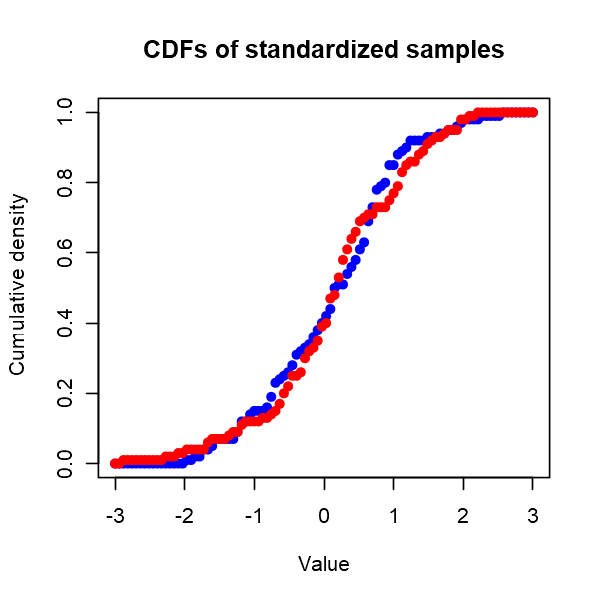

In [33]:
# Have to standardize the x-values
x_seq = seq(-3,3,len=100)
y_cdf1 = sapply(x_seq, function(x){
  sum(norm1<x)/length(norm1)
})
y_cdf2 = sapply(x_seq, function(x){
  sum(norm2<x)/length(norm1)
})

plot(x_seq,y_cdf1, col='blue', pch=16, main ='CDFs of standardized samples', 
     xlab = 'Value', ylab = 'Cumulative density')
points(x_seq,y_cdf2,col='red', pch=16) 

Notice that the plot of the standardized data iis a bit smoother, but otherwise quite similar.

The code in the cell below computes the point with the maximum distance between the quantiles for  the two samples. Execute the code and examine the result. 

[1] 0.1

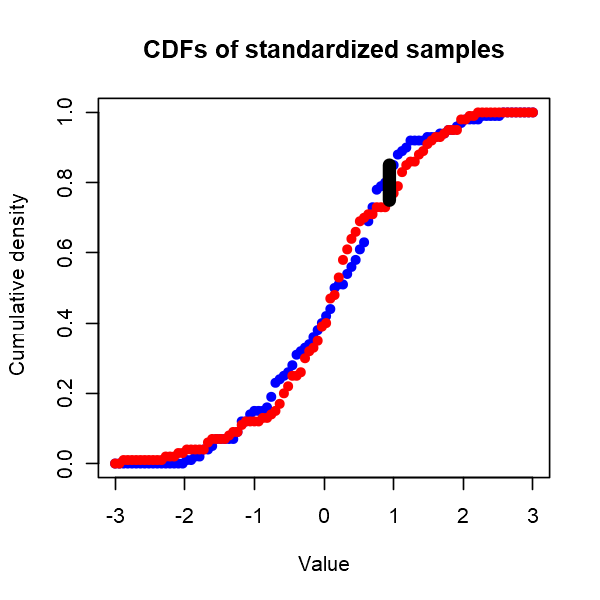

In [34]:
## Find the max deviation
k_s_stat = max(abs(y_cdf1 - y_cdf2))
k_s_stat
# where does it occur?
k_index = which.max(abs(y_cdf1-y_cdf2))
k_s_x = x_seq[k_index]
plot(x_seq,y_cdf1, col='blue', pch=16, main ='CDFs of standardized samples', 
     xlab = 'Value', ylab = 'Cumulative density')
points(x_seq,y_cdf2,col='red', pch=16) 
lines(c(k_s_x,k_s_x), c(y_cdf1[k_index],y_cdf2[k_index]),
      col='black', lwd=8)

Next, it's time to compute the K-S statistic and examine the distribution. The code in the cell below computes realizations of the K-S statistic and plots the histogram and density estimate.

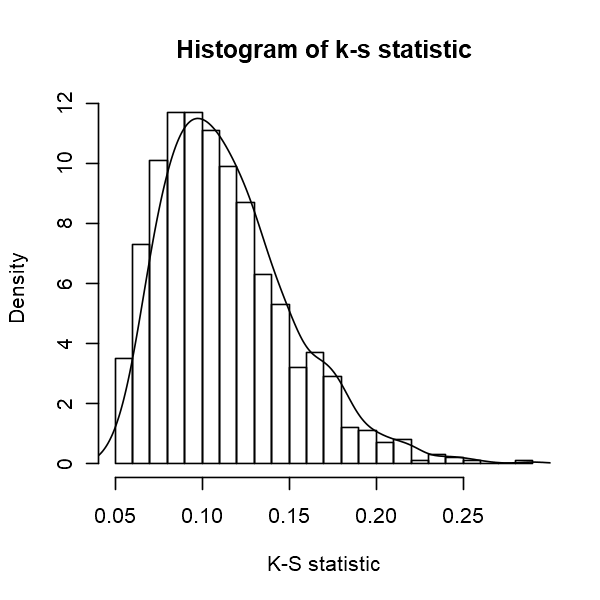

In [35]:
# Create k-s statistic function
ks_stat = function(x_min,x_max, dist_a, dist_b){
  x_seq = seq(x_min,x_max,len=1000)
  y_cdf1 = sapply(x_seq, function(x){
    sum(dist_a<x)/length(dist_a)
  })
  y_cdf2 = sapply(x_seq, function(x){
    sum(dist_b<x)/length(dist_b)
  })
  k_s_stat = max(abs(y_cdf1-y_cdf2))
  return(k_s_stat)
}


##----Repeat N Times-----
N = 1000
k_s_rep = sapply(1:N, function(i){
  dist_a = rnorm(100,mean=0,sd=1)
  dist_b = rnorm(100,mean=0,sd=1)
  return(ks_stat(-3, 3, dist_a, dist_b))
})

hist(k_s_rep, breaks=30, freq=FALSE, xlab = 'K-S statistic',
     main = 'Histogram of k-s statistic')
lines(density(k_s_rep))


Next, let's see how the KS-test works for testing two quite different distributions, the Normal and Uniform. The code is the cell below computes the KS-statistics to test the Normality of a Normal distribution and a Uniform distribution. Execute this code and examine the results. Do these results appear as you expect?

In [36]:
## Another example
n1 = rnorm(100) ## Standard Normal distribution
u1 = runif(100) ## Uniform distribution
nn = rnorm(100) ## Our standard Normal for comparison.
ks.test(n1, nn, alternative = "two.sided") 
ks.test(u1, nn, alternative = "two.sided") 


	Two-sample Kolmogorov-Smirnov test

data:  n1 and nn
D = 0.11, p-value = 0.5806
alternative hypothesis: two-sided



	Two-sample Kolmogorov-Smirnov test

data:  u1 and nn
D = 0.47, p-value = 5.099e-10
alternative hypothesis: two-sided


The K-S test is rather general, as it can be applied to test any distribution. However, this means that the **power** of this test is limited. The power of a test is the probability of rejecting a null hypothesis when the alternative is true. 

As is always the case with clasical statistics, a more powerful test can be created by adopting more restrictive assuptions. For example, the Shapiro-Wilk test has greater power, but is specifically for Normal distributions. 

## Testing Multiple Groups and ANOVA

So far, we have only looked at tests for comparing two samples. What if we had multiple groups and we wanted to compare their means? Why can’t we just do multiple two-sample t-tests for all pairs?
- Results in increased probability of accepting a false hypothesis.
- E.g., if we had 7 groups, there would be (7 Choose 2)=21 pairs to test.  If our alpha cutoff is 5%, then we are likely to accept about 1 false hypothesis (21*0.05).

There is another alternative:

- Null Hypothesis: All groups are just samples from the same population.
- Alternative Hypothesis: At least one group has a statistically different mean.

This type of analysis is called “ANalysis Of VAriance”, or ANOVA. ANOVA is one of a large family of models used for **experimental design**.

### History of ANOVA

ANOVA is not a new idea. 

- Laplace pioneered multiple comparison methods in 1827.
- Ronald A Fisher published seminal work inn 1922, 1925 and 1935. The F (Fisher) statistic is named in his honor.

![](img/Ronald_Fisher.jpg)
<center>**Ronald A. Fiher**, another scary looking statistics professor!</center>
<center>By Flikr commons [CC BY 2.0 (http://creativecommons.org/licenses/by/2.0)], via Wikimedia Commons</center>   

Fisher pionered the use of linear models for testing multiple groups (ANOVA) and the design of experiments to ensure meaningful analysis. Fisher had an overwhelming influence on the theory of classical (frequentist) statistics. Fisher was vehemently opposed to Baysian methods, and ostracized any practitioners. In fact, Fisher's long shadow explains why we are only begining to teach Bayesian methods in the 21st century. Unfortunately, as with Pearson, Fisher was also a eugenicist and a raceist.

Fisher's two books are still infulential and in print. 

![](img/Fisher1.jpg)

![](img/Fisher2.jpg)

<center>**Fisher's books of 1935 and 1925**</center>


### Basic ANOVA Theory 

How do we compare the means of these multiple groups? Can’t we just do multiple two-sample t-tests for all pairs?
- Results in increased probability of accepting a false hypothesis.
- For example, if we had 7 groups, there would be (7 Choose 2)=21 pairs to test.  If our alpha cutoff is 5%, then we are likely to accept about 1 false hypothesis (21*0.05)!

First, make data independence and Normality assumptions about the groups. Then define:

$$ I = number\ of\ treatments\\
n = number\ of\ data\ or\ samples\\
SS = sum\ of\ squares$$

We can calulate the following quantities:

$$SST = SS\ Treatment\\
SSE = SS\ Error\ within\ groups\\
SS-Total = SST + SSE$$

Further, 

$$ DFT = degrees\ of\ freedom\ Treatment\\
DFE = degrees\ of\ freedom\ Error\ within\ groups\\
DF-Total = DFT + DFE = (I-1) + (n-I) = n -1$$

And,

$$MST = mean\ square\ error\ Treatment\\
MSE = mean\ square\ error\ within\ groups$$

Finally we can compute the F ststistic with $I-1$ degrees of freedom:

$$F = \frac{Variance\ between\ treatments}{Variance\ within\ treatments} = \frac{MST}{MSE} =  \frac{\frac{SST}{DFT}}{\frac{SSE}{DFE}}$$

The F statistic on the degrees of freedom determines the significance or p-values of the test. 

We can lay these results out in an ANOVA table:

|Type|Sum of Squares|df|Mean Square E|F|Significance|
|---|---|---|---|---|---|
|Between Groups|SST|DFT|SST/DFT|F Statistic| p-value|
|Within Groups|SSE|DFE|SSE/DFE|||
|Groups Total|SS-Total|DF-Total||||


### ANOVA Example

Let's start with an example with 4 groups. In Fisher's experimental design terminology we say we have data from 4 **treatments**. Run the code below and examine the difference in the box plots.

**Note** the results you get with the ANOVA example will depend on the realizations of the values you compute. This is to be expected when working with samples from a probability distribution.

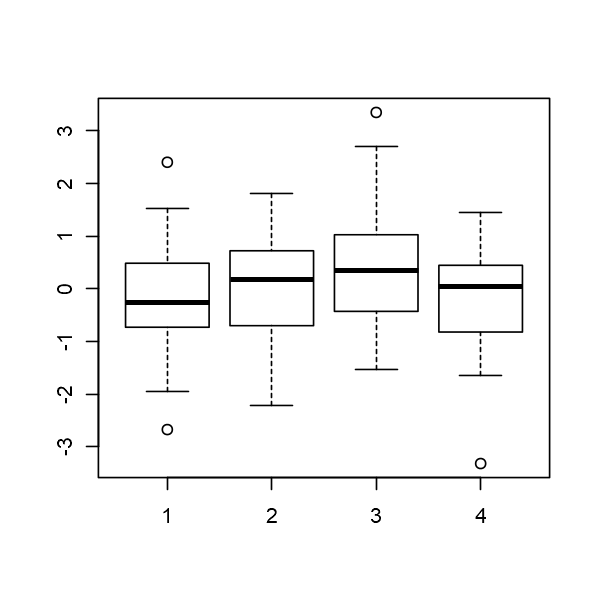

In [37]:
df = data.frame('group'=c(rep(1,50),
                          rep(2,50),
                          rep(3,60),
                          rep(4,40)),
                'val' = c(rnorm(50, mean=0, sd=1),
                          rnorm(50, mean=0, sd=1),
                          rnorm(60, mean=0.5, sd=1),
                          rnorm(40, mean=0, sd=1)))
df$group = factor(df$group) # Make sure your groups are a factor (for further analysis below)
boxplot(df$val ~ df$group)

The code in the cell below applies the R `aov` function to the data. This function uses the R formula language to define the model:

$$dependent\ variable\sim indepenent\ variables$$

For example, if the dependent variable (dv) is modeled by two independent variables (var1 and var2) the formula would be:

$$depvar \sim var1 + var2$$

The code in the cell below models the anova of the values, `val`, by the group and prints a summary of the model. Run this code and examine the results. 

In [38]:
df_aov = aov(val ~ group, data = df)
summary(df_aov)
print(df_aov)

             Df Sum Sq Mean Sq F value Pr(>F)  
group         3  10.08   3.361   3.365 0.0197 *
Residuals   196 195.79   0.999                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Call:
   aov(formula = val ~ group, data = df)

Terms:
                    group Residuals
Sum of Squares   10.08386 195.79316
Deg. of Freedom         3       196

Residual standard error: 0.9994722
Estimated effects may be unbalanced


From the ANOVA table printed you can see that there is a significant difference between at least some of the groups. Note the p-value, which should be less than 0.05, but will depend on the realization of the data values you computed. From the box plot, we could guess it that group 3 is different, but we really don't know.

### Power for ANOVA tests

But, what about the power of ANOVA tests? The code in the cell below computes the required number of observations per group for ANOVA for 3 to 100 groups. This calculation is performed for power of both 0.95 and 0.99, an F-statistic of 0.1, and a significance level of 0.05. 

Execute this code an examine the results. Keeping in mind that ANOVA only tells us if there is a difference between groups, but not which groups are different, are these results surprising? 

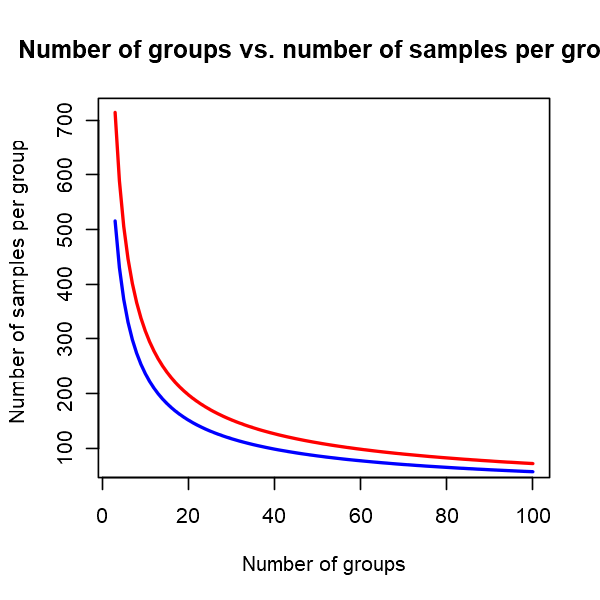

In [39]:
X = seq(from = 3, to = 100, length.out = 98)

powers = sapply(X, function(x) 
    pwr.anova.test(k = x, n = NULL, f = 0.1, sig.level = 0.05, power = 0.99)$n)
    plot(X, powers, type = 'l', lwd = 2, col = 'red',
    xlab = 'Number of groups', ylab = 'Number of samples per group',
    main = 'Number of groups vs. number of samples per group')
    
powers = sapply(X, function(x) 
    pwr.anova.test(k = x, n = NULL, f = 0.1, sig.level = 0.05, power = 0.95)$n)
lines(X, powers, type = 'l', lwd = 2, col = 'blue')    

### Turkey's ANOVA: Telling Groups Apart

John Tukey proposed a test, which he dubbed the HSD, Honest Significanat Differences, test. The test exaustively computes the following for each pair of groups:
- Difference of the means
- Confidence interval of the difference in the means
- A p-value from the distribution of the differences

These results are laid out in a table or can be plotted graphically. Only differences in means with a confidence interval not overlapping zero are considered significant.

The cells below contain the code to compute the Tukey HSD for the example. Run this code and examine the results. Which differences are significant?

In [40]:
tukey_anova = TukeyHSD(df_aov)  # Tukey's Range test:
tukey_anova

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = val ~ group, data = df)

$group
          diff         lwr         upr     p adj
2-1  0.1318993 -0.38606863  0.64986731 0.9119674
3-1  0.4730149 -0.02290171  0.96893145 0.0676133
4-1 -0.1090392 -0.65842723  0.44034877 0.9556040
3-2  0.3411155 -0.15480105  0.83703211 0.2849102
4-2 -0.2409386 -0.79032658  0.30844942 0.6674875
4-3 -0.5820541 -1.11070296 -0.05340526 0.0245663


Examine the table above. Which, pairs have a significant difference at the 95% confidence level. The confidence interval will not overlap 0 when the difference is significant. Which pair have a significant difference will depend on the realization of the data values you computed

Plot these figures and examine the results.

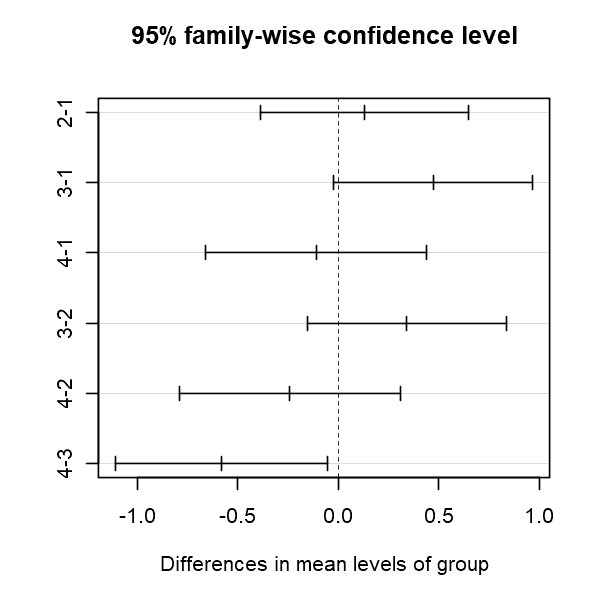

In [41]:
plot(tukey_anova)

Examine the plot above. Which, pairs have a significant difference at the 95% confidence level. The confidence interval (shown by the length of the bar) will not overlap 0 when the difference is significant. Which pair have a significant difference will depend on the realization of the data values you computed

## Clasical Tests and Big Data

With the increasing scale of data sets in the 21st Century, problems with the correct applicaton of classical tests have been amplified. The primary issue is with false positives, or **Type I errors**. This problem is known as the problem of **multiple comparisons** or **base rate fallacy**. 

To understand this problem lets look at a simple example. If we have 7 groups, there are 21 possible interactions between the groups. If we use a t-test with a significance level of 0.05, we expect there to be one false positive, even if the null hypothesis is true in all cases. 

These problems grow as the number of groups grow. As an example, consider classifing several millions objects from images. 

When there are relatively few groups with a great many cases there is no problem. The test will have ample power.

With large numbers of groups, there is a high probability of getting a false positive, or type I error, with ANOVA. Without any way to know which groups are different, it is nearly impossible to determine which group may or may not be different from the rest of the population. This is a manifestation of the base rate fallacy. 

### Bonfirroni correction  

Several adjustments to the multiple comparisons problem have been proposed. In 1979 Holm published a method know as the **Bonfirroni correction**. The adjustment is simple:

$$\alpha_b = \frac{\alpha}{m}\\
with\\ 
m =\ number\ of\ groups$$

The problem with the Bonfirroni correction is the reduction in power as the  grows smaller. For big data problems with large numbers of groups, this issue can be especially serious. 

### Confidence and credible intervals

Another approach to the base rate falacy problem is to use **confidence intervals**. For example, one can compute the confidence intervals of the distributions of differences of means between groups. We have just seen an example with Tukeys HSD method. 

Interpretation of confidence intervals is quite straight forward, especailly when compared to p-values. If the confidence intervals for the difference in means do not overlap 0 the difference in means is significant. 

The confidence intervals can be adjusted analogously to the Bonfirroni correction. This process does not have the problem with the reduction in power.   

Yet another approach is to use the Bayesian **credible interval**. While the computation is different, the intrepretation is intuitive, and analogous to interpretation of confidence intervals. 

## Summary

We have covered lot of ground in this lesson. Specifically we have discussed:

- Mean comparison tests in the form of the t-test.
- The $\chi$-squared test for count data. 
- Distribution comparison tests in the form of the K-S test.
- Variance comparison test for multiple groupd in the form of ANOVA.
- The meaning of the p-value or significance level. 
- Power of tests.
- Issues with applying tests to big data problems. 

## Suplementary Material

If you need some review of the concepts of classical statistics there are numerous good books available. Two particuarly non-mathematical and readable books are shown below. These books have distinct and diferent styles. If you do not like one, you might like the other. Or, you may benefit from reading both. 

Alex Reinhart's book, *Statistics Done Wrong, a woefully complete guide*, No Starch Press, 2015, disscusses clasical statistical tests using numerious clever examples. 

![](img/StatsDoneWrong.jpg)

Andrew Vicker's *What is a P-Value Anyway*, Pearson, 2009, is perhaps the most humorous statistics book ever writen; admittidly a category with little competition. The treatment is a bit broader than Reinhart's book. 

![](img/p-value.jpg)


##### Copyright 2017, Stephen F Elston. All rights reserved.